# Example use of gore module #
This notebook demonstrates basic use of the gore module to
- Read a fundus image from file
- Produce a map where each pixel of the fundus image has been mapped to a point in the eye
- Produce an interrupted projection of this map (a set of gores) for assembly; we add a "no-cut zone" between gores, so that the gores are connected by a strip to avoid fiddly cutting.

## Gores with image centred at the "equator"
The default behaiour is the position the gores such that they are joined along what would be the equator on a globe.
Import `gore` module and other utilities

In [1]:
import sys  
sys.path.insert(0, './gore')
import gore2
from math import pi
from nbutils import fig

Open the example input image using `Image.open()` and display

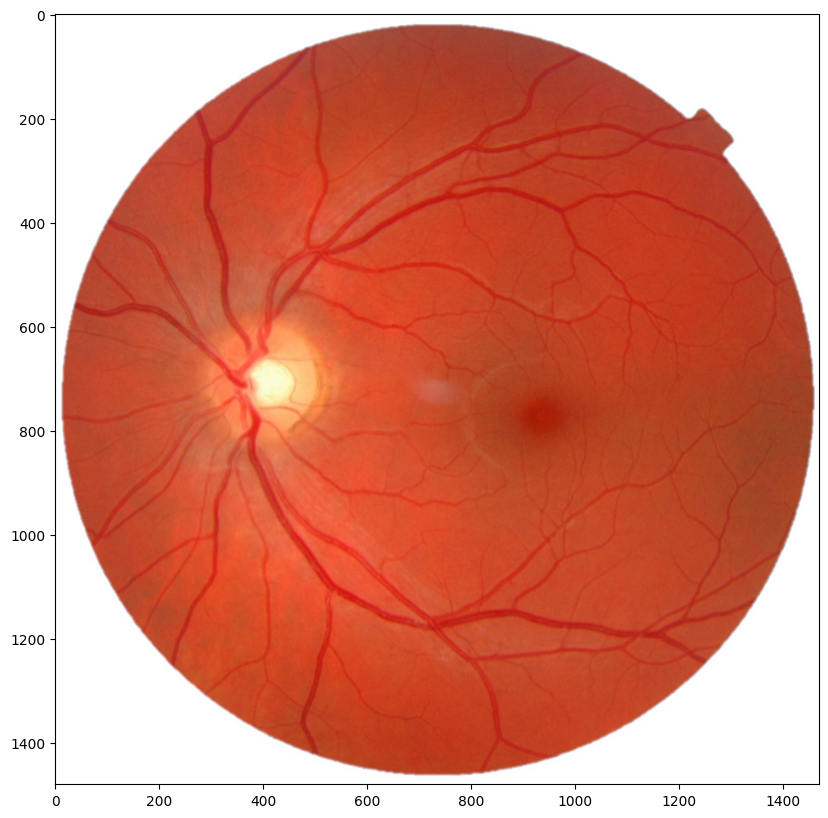

In [2]:
image = gore2.Image.open('./img/img1.jpg')
fig(image)

Map the image to position in the eye using the simple eye model and get its angular size.
First we open the image using `image_from_path()`

In [3]:
im = gore2.image_from_path('./img/img1.jpg')

Now use `equi` to map the image.

In [4]:
# parameters
angular_size = gore2.deg2rad(32) # angular size of fundus image

fundus_equi, lammax, phimax = gore2.equi(im = im, alpha_max = angular_size)

Using the output of the previous function, produce a set of six gores using the Cassini projection.

In [5]:
#parameters
num_gores = 6
projection = gore2.Projection.CASSINI # default projection: sinusoidal also available

fundus_gores = gore2.make_equatorial(fundus_equi, num_gores = num_gores, projection = projection, 
                         phi_min = -phimax, phi_max = phimax, lam_min = -lammax, 
                         lam_max = lammax)

Finally, display the resulting gores.

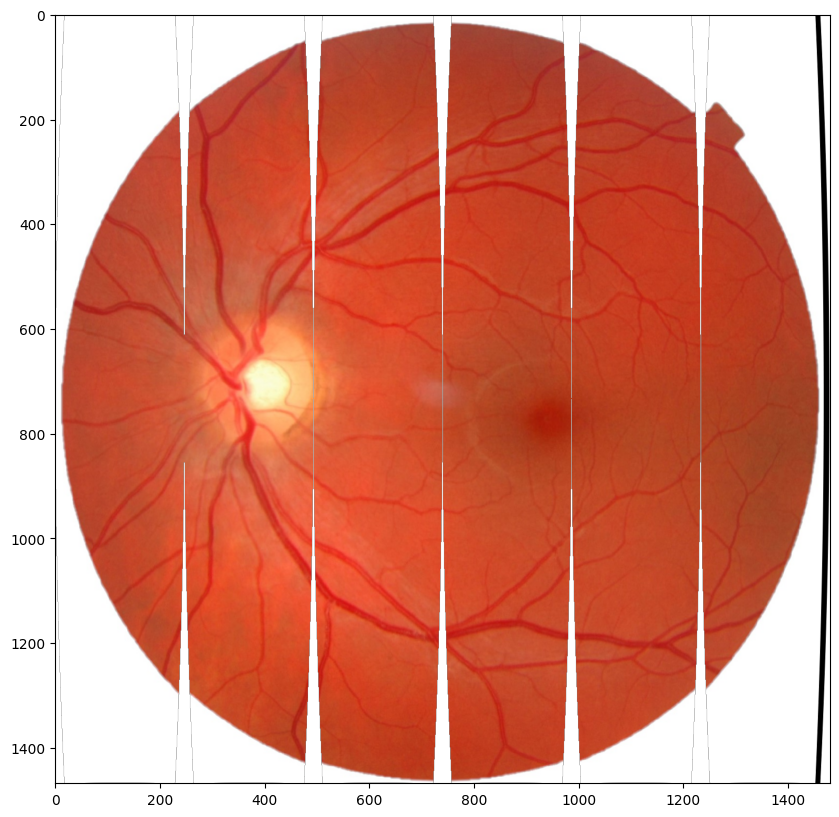

In [6]:
fig(fundus_gores)

## Joining at the pole
Produce a set of gores joined at the pole. Until now the centre of the fundus image has been centred on the equator of our map of the eye; the function that creates the rotary pattern of gores expects the region of interest to be centred at the "north" pole, so we use the function `swap` to rotate our map of the eye so that it is correctly oriented.

In [7]:
fundus_swapped = gore2.swap(fundus_equi, phi_extent = phimax, lam_extent = lammax)

The next function we will use to create gores joined at the pole expects an image whose width is twice its height, so resize first:

In [8]:
height, width = fundus_swapped.shape[:2]
fundus_swapped = gore2.cv2.resize(fundus_swapped, (width * 2, height)) 

Now use `make_polar` to join the gores at the pole:

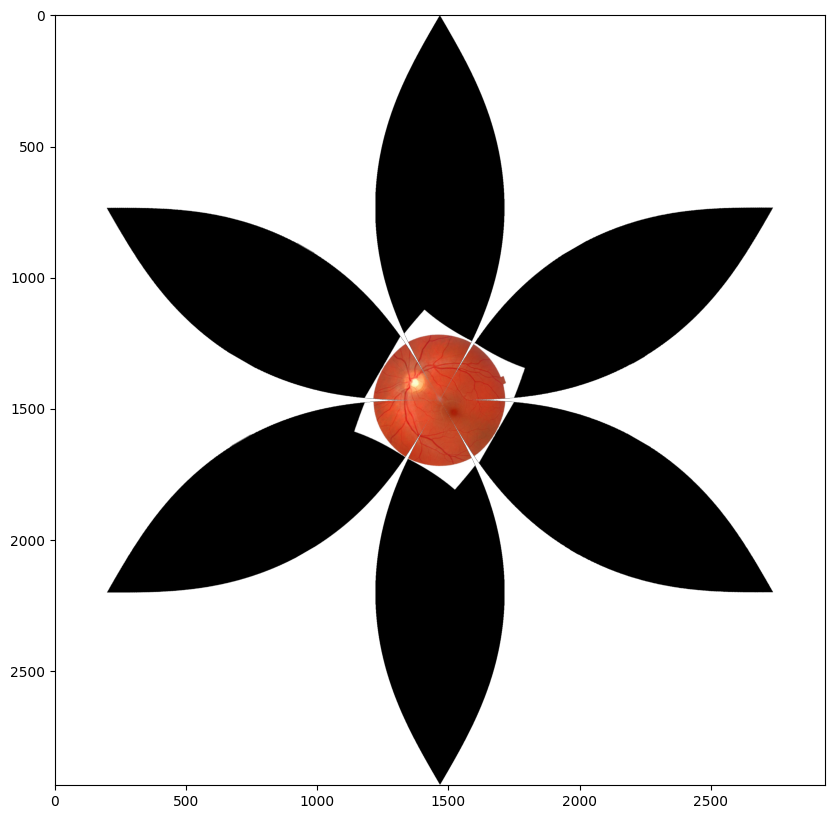

In [9]:
fundus_rotary = gore2.make_polar(fundus_swapped, num_gores = 6)
fundus_rotary.save("fundus_rotary.png")
fig(fundus_rotary)

Finally, produce a polar cap using a simple projection (azimuthal equidistant) that can be pasted on to the rotary gores, so that there is a region in the centre where no cutting is required.

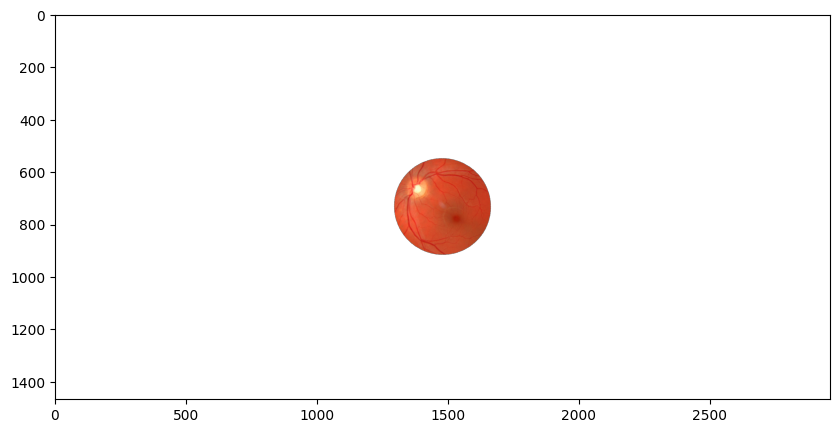

In [10]:
fundus_cap = gore2.polecap(fundus_swapped, num_gores=6, phi_cap = pi / 8)
fundus_cap.save("fundus_cap.png")
fig(fundus_cap)

## Putting it all together in one function
The stages of calculating the fundus positions, creating gores centred at the pole, creating a pole cap and pasting together is accomplished by `make_rotary()`

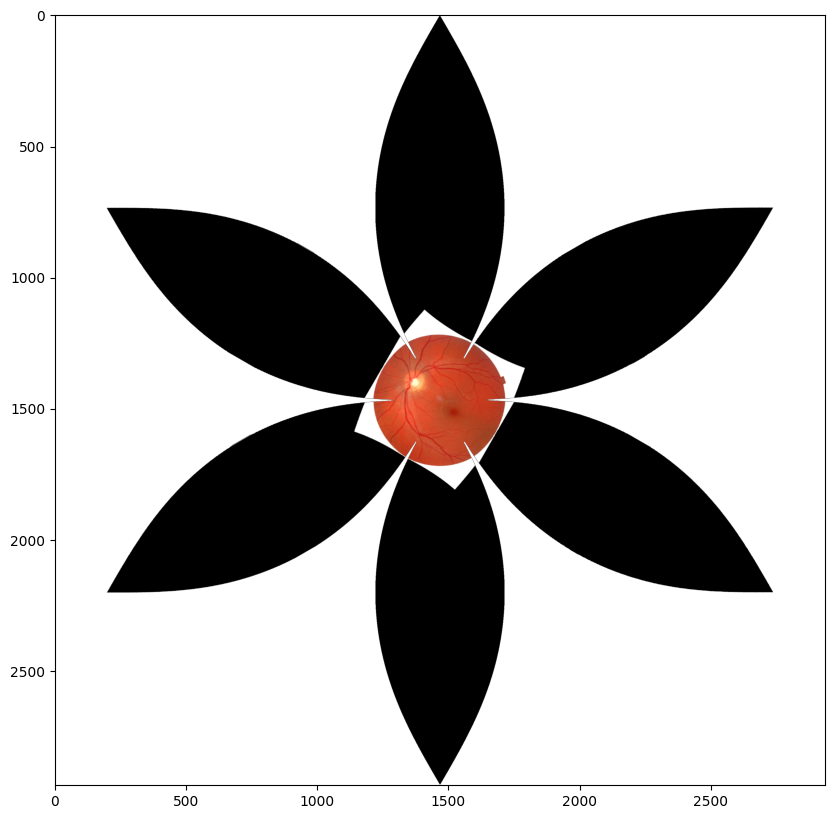

In [11]:
rotary_gores = gore2.make_rotary (im, alpha_max=angular_size, num_gores=6, phi_no_cut = pi / 8)
rotary_gores.save("rotary_gores.png")
fig(rotary_gores)

Finally, there is an alernative function to `make_rotary()`: `make_rotary_adjusted()`, which takes an image path as one of its arguments, plus some additional options such as rotation and image quality:

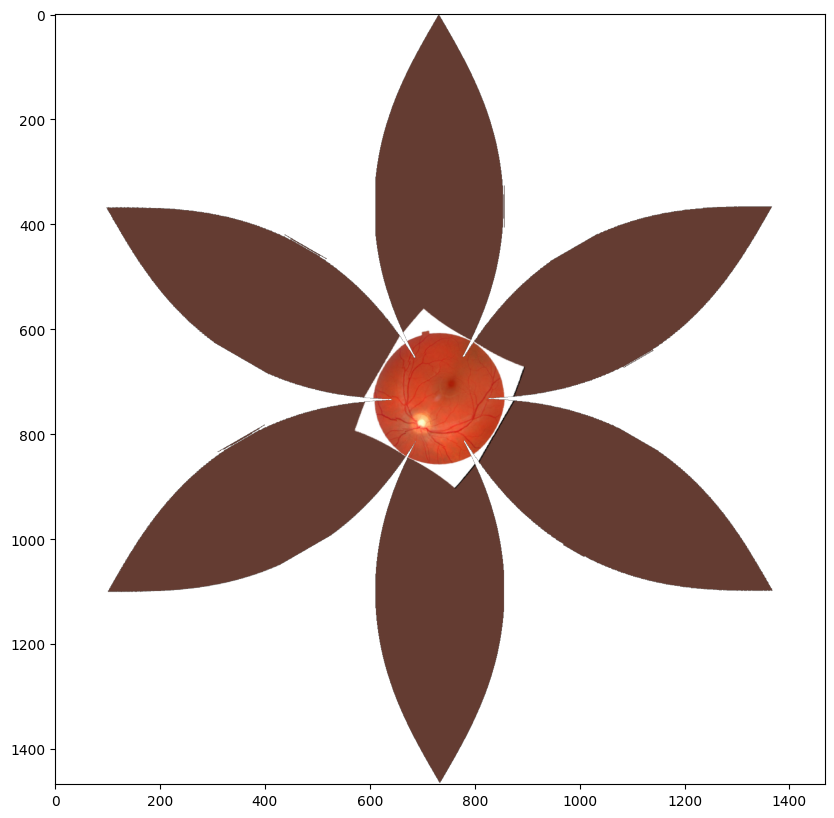

In [12]:
rotary_gores_adjusted = gore2.make_rotary_adjusted(
                          image_path = './img/img1.jpg',
                          alpha_max = angular_size,
                          num_gores = 6,
                          phi_no_cut = pi / 8,
                          rotation = 90,
                          quality = 50,
                          alpha_limit = pi,
                          projection = gore2.Projection.CASSINI,
                          background_colour = (100,60,50,50))
fig(rotary_gores_adjusted)